---
title: "Smith-Waterman Local Alignment using Python"
execute: 
  enabled: false
  freeze: true
date: "9/16/2024"
<!-- date-modified: "6/23/2024" -->
categories: [bioinformatics, alignment, smith-waterman, biopython]
---


> Smith-Waterman is a local alignment method for sequence alignment. Below is example implementation using python.

:::{.callout-note}
This post was written using:
<br>- `biopython`: 1.78
:::

In [1]:
from typing import Union, List

from Bio import Align

In [2]:

def get_score(A:str, B:str, mismatch_penalty:int, match_score:int) -> int:
    # match
    if A == B:
        return match_score
    
    # mismatch
    return mismatch_penalty

def init_matrix(A: str, B: str) -> list:
    lenA = len(A) + 1
    lenB = len(B) + 1
    matrix = []
    for i in range(lenB):
        matrix.append([0] * lenA)

    return matrix


def noNeg(x:int) -> int:
    return max(0, x)


def SmithWaterman(A, B, gap_penalty:int=-2, mismatch_penalty:int=-1, match_score:int=4) -> Union[list, int, list]:
    """ initialize matrix and fill

    Returns:
        list: 2D array of filled value according to Smith-Waterman algorithm
        int: Max value in the final filled `matrix`
        list: List of position [row, col] of `max_score` in `matrix`

    """
    matrix = init_matrix(A, B)

    # in sw, lower bound to 0
    for m in range(len(matrix)):
        for n in range(len(matrix[0])):
            matrix[m][n] = noNeg(matrix[m][n])

    diag = [[-1, -1]]
    top = [[-1, 0]]
    left = [[0, -1]]

    max_score = 0
    max_score_position = []

    for row in range(1, len(B)+1):
        for col in range(1, len(A)+1):
            a_char = A[col-1]
            b_char = B[row-1]

            for dr,dc in left:
                l = matrix[row + dr][col + dc] + gap_penalty

            for dr,dc in top:
                t = matrix[row + dr][col + dc] + gap_penalty
            
            for dr,dc in diag:
                d = matrix[row + dr][col + dc] + get_score(a_char, b_char, mismatch_penalty, match_score)

            # l,t,d lower bouded to 0 (SW property)
            cur_score = max(noNeg(l), noNeg(t), noNeg(d))
            if cur_score > max_score:
                max_score = cur_score
                max_score_position = [row, col]

            matrix[row][col] = cur_score

    return matrix, max_score, max_score_position


In [3]:
def traceback(matrix: list, A: str, B: str,
              max_score_position: list, 
              gap_penalty: int,
              mismatch_penalty: int,
              match_score: int) -> List[str]:
    aligned_A = []
    aligned_B = []

    row = max_score_position[0]
    col = max_score_position[1]

    while row > 0 and col > 0:
        d = matrix[row - 1][col - 1]
        t = matrix[row - 1][col]
        l = matrix[row][col - 1]

        # Stop when we reach a score of 0 (SW property)
        if matrix[row][col] == 0:
            break

        # Diagonal move (match/mismatch)
        if matrix[row][col] == d + get_score(A[col-1], B[row-1], mismatch_penalty, match_score):
            aligned_A.append(A[col-1])
            aligned_B.append(B[row-1])
            row -= 1
            col -= 1
        # Left move (gap in B)
        elif matrix[row][col] == l + gap_penalty:
            aligned_A.append(A[col-1])
            aligned_B.append('-')
            col -= 1
        # Top move (gap in A)
        elif matrix[row][col] == t + gap_penalty:
            aligned_A.append('-')
            aligned_B.append(B[row-1])
            row -= 1

    return ''.join(reversed(aligned_A)), ''.join(reversed(aligned_B))


In [4]:
## Params

GAP_PENALTY = -2
MISMATCH_PENALTY = -1
MATCH_SCORE = 2


In [5]:


A, B = "AACG", "AATCG"  # A = top, B = left
matrix, max_score, max_score_position = SmithWaterman(A, B,
                                                      gap_penalty = GAP_PENALTY, 
                                                      mismatch_penalty = MISMATCH_PENALTY,
                                                      match_score = MATCH_SCORE)
for m in matrix:
    print(m)


[0, 0, 0, 0, 0]
[0, 2, 2, 0, 0]
[0, 2, 4, 2, 0]
[0, 0, 2, 3, 1]
[0, 0, 0, 4, 2]
[0, 0, 0, 2, 6]


In [1]:
max_score

6

In [2]:
max_score_position

[5, 4]

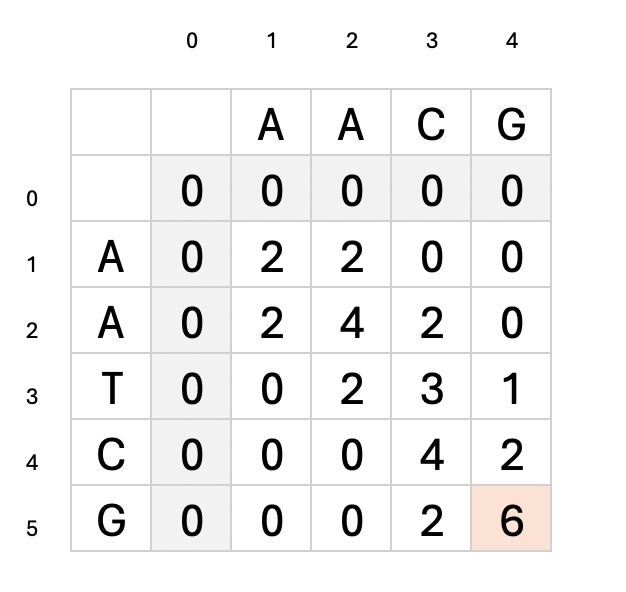

Above is the filled in matrix. The highlighted cell is the `max_score`.

# Traceback

In [6]:

aligned_A, aligned_B = traceback(matrix, A, B,
                                  max_score_position,
                                  gap_penalty = GAP_PENALTY,
                                  mismatch_penalty = MISMATCH_PENALTY,
                                  match_score = MATCH_SCORE)

print("Alignment:")
print(aligned_A)
print(aligned_B)


Alignment:
AA-CG
AATCG


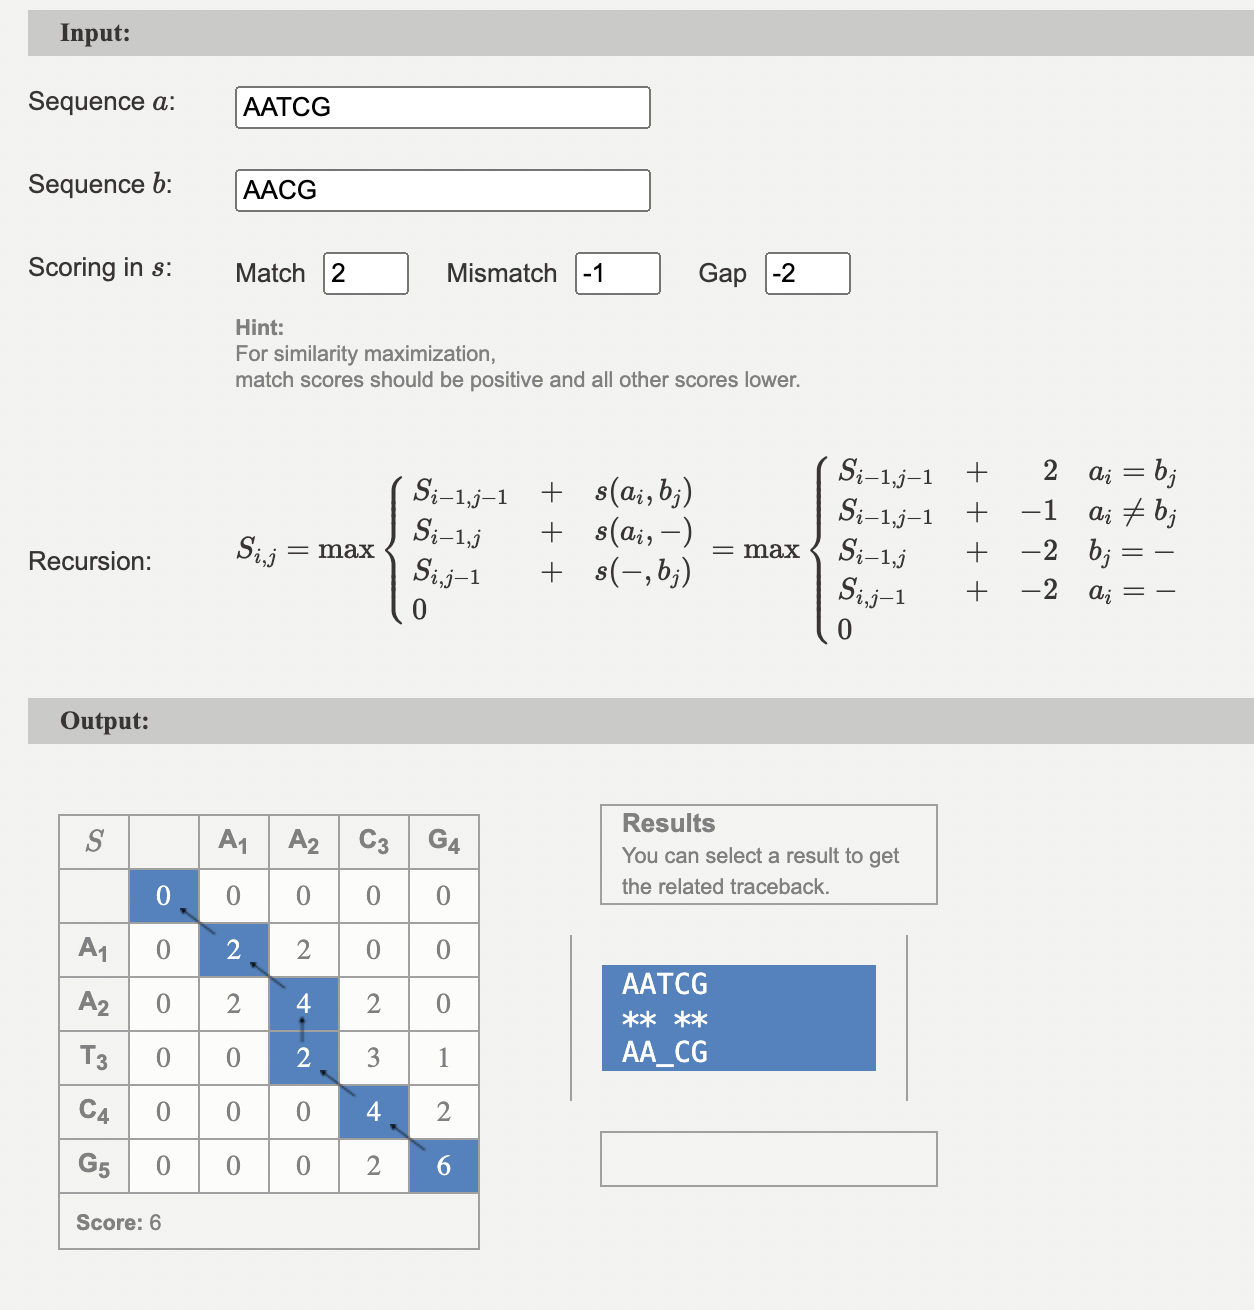

We get same output with <a href="http://rna.informatik.uni-freiburg.de/Teaching/index.jsp?toolName=Smith-Waterman">University of Freiburg Smith-Waterman Tool</a> (Ref 1). 

# Get alignment score

In [7]:
aligner = Align.PairwiseAligner()
aligner.mode = 'local'

alignments = aligner.align(aligned_A.replace('-',''), 
                           aligned_B.replace('-',''))

for alignment in sorted(alignments):
    print("Score = %.1f:" % alignment.score)
    print(alignment)

Score = 4.0:
AA-CG
||-||
AATCG



# References<br>
1. <a href="http://rna.informatik.uni-freiburg.de/Teaching/index.jsp?toolName=Smith-Waterman">University of Freiburg Smith-Waterman Tool</a><br>
1. <a href="https://www.ebi.ac.uk/jdispatcher/psa/emboss_water">EMBL-EBI Emboss Water Tool</a><br>
1. <a href="https://biopython.org/docs/1.76/api/Bio.Align.html#:~:text=Calling%20the%20%E2%80%9Cscore%E2%80%9D%20method%20on,alignments%20between%20the%20two%20sequences.">Biopython Align</a><br>
1. <a href="https://johnlekberg.com/blog/2020-10-25-seq-align.html">John Lekberg's Sequence Alignment Blogpost</a>

